# A transformer-based model based on "What does self-attention learn from Masked Language Modelling?" paper

### Core parts of the transformer
- Separated position and spin
- Single attention layer


### Outline
1. Vanilla attention implementation
2. Factored attention implementation


In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F

from utils import *
from train import *

In [69]:
X = torch.randn(100,1000,300)
idx = torch.randint(0,1000,(100,))
# create masked_X, Y=model(masked_X)
# X[:,idx,:]-Y[:,idx,:]

In [70]:
# Sequences for decoder
dec_chains_train = np.load('data/final_chains_T=1_num_iters=400_train.npy')
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", dec_chains_train.shape)

dec_chains_test = np.load('data/final_chains_T=1_num_iters=400_test.npy')
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", dec_chains_test.shape)


Loaded train sequences of proteins sampled from Boltzmann distribution: (1000, 200)
Loaded test sequences of proteins sampled from Boltzmann distribution: (1000, 200)


In [71]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Linear(max_seq_length, embed_dim)
        self.a = a  # parameter controlling how important positions are
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins)  # output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, s):
        #if not isinstance(s, torch.Tensor):
        s = torch.tensor(s, dtype=torch.float)

        position_ids = torch.arange(s.size(0), dtype=torch.float)
        x = self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)
        
        query = self.query_weight(x)
        key = self.key_weight(x)
        values = self.value_weight(x)
        
        # Simple attention score calculation (Dot product): this is equivalent to the interaction matrix
        scores = torch.matmul(query, key.transpose(-2, -1))  # Transpose last two dimensions for matrix multiplication
        scores = torch.softmax(scores, dim=-1)  # Apply softmax to scores to get probabilities

        # Apply attention scores to values
        attn_output = torch.matmul(scores, values)

        # Sum over the sequence length dimensions
        #print("attention before summing:", attn_output.shape)
        #attn_output = attn_output.sum(dim=0)
        #print("attention after summing:", attn_output.shape)
        output = self.fc(self.dropout(attn_output))

        return output, scores


In [87]:
def evaluate(model, data_test, vocab, criterion, device=0):
    model.eval()
    epoch_loss = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    for i, data in tqdm.tqdm(enumerate(data_test), total=len(data_test)):
        # Get the inputs
        input_seq = data
        input_one_hot = one_hot_encoding(input_seq.tolist(), vocab)
        # mask a token
        masked_sequence, positions = mask_random_spins(input_seq, vocab=vocab, pos=5, mask_token=2, one_hot_flag=True)
        # Forward pass
        outputs, attn_weights = model.forward(masked_sequence)

        #output_token = F.log_softmax(outputs, dim=-1)
        target_tokens = torch.where(input_one_hot[positions]==1)[1] #target_token = input_seq[position]

        # Compute loss
        loss = criterion(outputs[positions], target_tokens)
        epoch_loss += loss.item()
    #model.train()
    return epoch_loss / len(data_test)

def train(model, data_train, data_test, vocab, optimizer, criterion, num_epochs=8, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        attention_weights = []
        
        for i, data in tqdm.tqdm(enumerate(data_train), total=len(data_train)):
            # Get the inputs
            input_seq = data
            input_one_hot = one_hot_encoding(input_seq.tolist(), vocab)

            # mask a token
            masked_sequence, positions = mask_random_spins(input_seq, vocab=vocab, pos=5, mask_token=2, one_hot_flag=True)

            # Forward pass
            prediction, scores = model.forward(masked_sequence) #masked_sequence[masked_position]
            
            #predicted_token = F.log_softmax(prediction, dim=-1)
            target_tokens = torch.where(input_one_hot[positions]==1)[1]
            # Compute loss
            #print("predicted_token:", predicted_token)
            #print("predicted_token:", prediction[positions].shape)
            #print("target token:", target_tokens)
            loss = criterion(prediction[positions], target_tokens)
            epoch_loss += loss.item()
            
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            attention_weights.append(scores)
            
            running_loss += loss.item()
            if i % 10 == 9. :    # print every 10 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(data)):.4f}')
        eval_loss = evaluate(model, data_test, vocab, criterion, device=device)
        print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss):.4f}')
        
        # Perform early stopping based on eval loss
        if eval_loss < best_eval_loss:
            return epoch_loss / len(data_train)
    return epoch_loss / len(data_train), attention_weights


In [88]:
# Define the parameters 
vocab_size = 3
vocab = {-1:0,1:1,2:2} 
L = 200
embedding_dim = 200
hidden_dim = 200
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-3
num_sequences = 1000
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [89]:
# Example usage:
model = VanillaAttentionTransformer(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, dropout_rate=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss, attn_weights = train(model, dec_chains_train, dec_chains_test, vocab, optimizer, criterion, device=device)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)

  0%|          | 0/8 [00:00<?, ?it/s]/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_23859/992331038.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(s, dtype=torch.float)


[1,    10] loss: 0.090
[1,    20] loss: 0.083
[1,    30] loss: 0.094
[1,    40] loss: 0.081
[1,    50] loss: 0.072
[1,    60] loss: 0.075
[1,    70] loss: 0.072


[1,    80] loss: 0.071
[1,    90] loss: 0.073
[1,   100] loss: 0.075
[1,   110] loss: 0.069
[1,   120] loss: 0.080
[1,   130] loss: 0.072
[1,   140] loss: 0.068


[1,   150] loss: 0.073
[1,   160] loss: 0.072
[1,   170] loss: 0.069
[1,   180] loss: 0.071
[1,   190] loss: 0.072
[1,   200] loss: 0.069


[1,   210] loss: 0.071
[1,   220] loss: 0.071
[1,   230] loss: 0.074
[1,   240] loss: 0.070


[1,   250] loss: 0.070
[1,   260] loss: 0.072
[1,   270] loss: 0.066
[1,   280] loss: 0.080
[1,   290] loss: 0.070
[1,   300] loss: 0.067
[1,   310] loss: 0.071


[1,   320] loss: 0.075
[1,   330] loss: 0.071
[1,   340] loss: 0.070
[1,   350] loss: 0.070
[1,   360] loss: 0.070
[1,   370] loss: 0.070


[1,   380] loss: 0.075
[1,   390] loss: 0.069
[1,   400] loss: 0.077
[1,   410] loss: 0.070
[1,   420] loss: 0.072
[1,   430] loss: 0.071


[1,   440] loss: 0.070
[1,   450] loss: 0.069
[1,   460] loss: 0.072
[1,   470] loss: 0.070
[1,   480] loss: 0.070
[1,   490] loss: 0.068


[1,   500] loss: 0.073
[1,   510] loss: 0.072
[1,   520] loss: 0.071
[1,   530] loss: 0.073
[1,   540] loss: 0.070
[1,   550] loss: 0.072


[1,   560] loss: 0.068
[1,   570] loss: 0.066
[1,   580] loss: 0.068
[1,   590] loss: 0.075
[1,   600] loss: 0.066
[1,   610] loss: 0.071
[1,   620] loss: 0.070


[1,   630] loss: 0.069
[1,   640] loss: 0.067
[1,   650] loss: 0.063
[1,   660] loss: 0.067
[1,   670] loss: 0.073
[1,   680] loss: 0.073


[1,   690] loss: 0.071
[1,   700] loss: 0.071
[1,   710] loss: 0.067
[1,   720] loss: 0.074
[1,   730] loss: 0.068


[1,   740] loss: 0.069
[1,   750] loss: 0.068
[1,   760] loss: 0.071
[1,   770] loss: 0.070
[1,   780] loss: 0.067
[1,   790] loss: 0.067
[1,   800] loss: 0.071


[1,   810] loss: 0.069
[1,   820] loss: 0.067
[1,   830] loss: 0.073
[1,   840] loss: 0.073
[1,   850] loss: 0.070
[1,   860] loss: 0.070
[1,   870] loss: 0.070


[1,   880] loss: 0.070
[1,   890] loss: 0.069
[1,   900] loss: 0.071
[1,   910] loss: 0.069
[1,   920] loss: 0.070
[1,   930] loss: 0.069
[1,   940] loss: 0.069


[1,   950] loss: 0.071
[1,   960] loss: 0.070
[1,   970] loss: 0.069
[1,   980] loss: 0.073


100%|██████████| 1000/1000 [00:03<00:00, 280.67it/s]


[1,   990] loss: 0.068
[1,  1000] loss: 0.069
Epoch 1 | Train Loss: 3.5596


 12%|█▎        | 1/8 [00:05<00:35,  5.04s/it]

Epoch 1 | Eval Loss: 0.6980


[2,    10] loss: 0.068
[2,    20] loss: 0.074
[2,    30] loss: 0.070
[2,    40] loss: 0.070
[2,    50] loss: 0.070


[2,    60] loss: 0.067
[2,    70] loss: 0.070


[2,    80] loss: 0.073
[2,    90] loss: 0.071
[2,   100] loss: 0.069
[2,   110] loss: 0.070
[2,   120] loss: 0.070


[2,   130] loss: 0.070
[2,   140] loss: 0.070


[2,   150] loss: 0.067
[2,   160] loss: 0.073
[2,   170] loss: 0.070
[2,   180] loss: 0.069
[2,   190] loss: 0.070
[2,   200] loss: 0.070
[2,   210] loss: 0.068


[2,   220] loss: 0.068
[2,   230] loss: 0.073
[2,   240] loss: 0.069
[2,   250] loss: 0.070
[2,   260] loss: 0.069
[2,   270] loss: 0.067
[2,   280] loss: 0.072


[2,   290] loss: 0.071
[2,   300] loss: 0.070
[2,   310] loss: 0.071
[2,   320] loss: 0.070
[2,   330] loss: 0.070
[2,   340] loss: 0.070
[2,   350] loss: 0.069


[2,   360] loss: 0.071
[2,   370] loss: 0.070
[2,   380] loss: 0.070
[2,   390] loss: 0.068
[2,   400] loss: 0.075
[2,   410] loss: 0.069
[2,   420] loss: 0.070


[2,   430] loss: 0.068
[2,   440] loss: 0.071
[2,   450] loss: 0.070


[2,   460] loss: 0.070
[2,   470] loss: 0.070
[2,   480] loss: 0.070
[2,   490] loss: 0.069
[2,   500] loss: 0.069
[2,   510] loss: 0.068


[2,   520] loss: 0.073
[2,   530] loss: 0.072
[2,   540] loss: 0.070
[2,   550] loss: 0.070
[2,   560] loss: 0.067
[2,   570] loss: 0.069
[2,   580] loss: 0.068


[2,   590] loss: 0.074
[2,   600] loss: 0.068
[2,   610] loss: 0.070
[2,   620] loss: 0.069
[2,   630] loss: 0.071
[2,   640] loss: 0.069
[2,   650] loss: 0.063


[2,   660] loss: 0.073
[2,   670] loss: 0.075
[2,   680] loss: 0.071
[2,   690] loss: 0.070
[2,   700] loss: 0.070
[2,   710] loss: 0.071
[2,   720] loss: 0.070


[2,   730] loss: 0.070
[2,   740] loss: 0.069
[2,   750] loss: 0.070
[2,   760] loss: 0.069
[2,   770] loss: 0.072
[2,   780] loss: 0.069
[2,   790] loss: 0.070


[2,   800] loss: 0.070
[2,   810] loss: 0.069
[2,   820] loss: 0.065
[2,   830] loss: 0.071
[2,   840] loss: 0.073
[2,   850] loss: 0.070


[2,   860] loss: 0.069
[2,   870] loss: 0.070
[2,   880] loss: 0.069
[2,   890] loss: 0.068
[2,   900] loss: 0.071
[2,   910] loss: 0.071
[2,   920] loss: 0.069


[2,   930] loss: 0.069
[2,   940] loss: 0.069
[2,   950] loss: 0.069
[2,   960] loss: 0.070
[2,   970] loss: 0.070
[2,   980] loss: 0.070
[2,   990] loss: 0.069


100%|██████████| 1000/1000 [00:03<00:00, 299.70it/s]


[2,  1000] loss: 0.068
Epoch 2 | Train Loss: 3.4927


 25%|██▌       | 2/8 [00:09<00:29,  4.86s/it]

Epoch 2 | Eval Loss: 0.7008


[3,    10] loss: 0.071
[3,    20] loss: 0.070
[3,    30] loss: 0.070
[3,    40] loss: 0.069
[3,    50] loss: 0.069


[3,    60] loss: 0.069
[3,    70] loss: 0.070


[3,    80] loss: 0.070
[3,    90] loss: 0.069


[3,   100] loss: 0.070
[3,   110] loss: 0.070
[3,   120] loss: 0.070
[3,   130] loss: 0.069


[3,   140] loss: 0.067
[3,   150] loss: 0.069
[3,   160] loss: 0.072


[3,   170] loss: 0.071
[3,   180] loss: 0.068
[3,   190] loss: 0.069


[3,   200] loss: 0.070
[3,   210] loss: 0.068
[3,   220] loss: 0.068
[3,   230] loss: 0.071


[3,   240] loss: 0.069
[3,   250] loss: 0.070


[3,   260] loss: 0.071
[3,   270] loss: 0.069
[3,   280] loss: 0.070
[3,   290] loss: 0.069


[3,   300] loss: 0.070
[3,   310] loss: 0.069


[3,   320] loss: 0.069
[3,   330] loss: 0.069
[3,   340] loss: 0.069
[3,   350] loss: 0.069


[3,   360] loss: 0.071
[3,   370] loss: 0.070


[3,   380] loss: 0.070
[3,   390] loss: 0.069
[3,   400] loss: 0.070
[3,   410] loss: 0.070
[3,   420] loss: 0.069
[3,   430] loss: 0.070


[3,   440] loss: 0.069
[3,   450] loss: 0.069
[3,   460] loss: 0.069
[3,   470] loss: 0.069


[3,   480] loss: 0.071


[3,   490] loss: 0.069
[3,   500] loss: 0.070
[3,   510] loss: 0.069
[3,   520] loss: 0.070
[3,   530] loss: 0.070
[3,   540] loss: 0.070


[3,   550] loss: 0.070


[3,   560] loss: 0.069
[3,   570] loss: 0.069
[3,   580] loss: 0.068
[3,   590] loss: 0.074


[3,   600] loss: 0.068
[3,   610] loss: 0.071
[3,   620] loss: 0.070
[3,   630] loss: 0.069
[3,   640] loss: 0.069
[3,   650] loss: 0.063


[3,   660] loss: 0.069
[3,   670] loss: 0.070
[3,   680] loss: 0.070
[3,   690] loss: 0.069
[3,   700] loss: 0.067
[3,   710] loss: 0.073
[3,   720] loss: 0.068


[3,   730] loss: 0.070
[3,   740] loss: 0.070
[3,   750] loss: 0.070
[3,   760] loss: 0.069
[3,   770] loss: 0.069
[3,   780] loss: 0.068


[3,   790] loss: 0.069


[3,   800] loss: 0.070
[3,   810] loss: 0.070
[3,   820] loss: 0.067
[3,   830] loss: 0.070
[3,   840] loss: 0.070
[3,   850] loss: 0.070


[3,   860] loss: 0.069
[3,   870] loss: 0.069


[3,   880] loss: 0.068


[3,   890] loss: 0.065
[3,   900] loss: 0.067
[3,   910] loss: 0.071
[3,   920] loss: 0.069
[3,   930] loss: 0.068
[3,   940] loss: 0.069


[3,   950] loss: 0.070


100%|██████████| 1000/1000 [00:03<00:00, 269.80it/s]


[3,   960] loss: 0.071
[3,   970] loss: 0.072
[3,   980] loss: 0.068
[3,   990] loss: 0.071
[3,  1000] loss: 0.069
Epoch 3 | Train Loss: 3.4712


 38%|███▊      | 3/8 [00:14<00:24,  4.98s/it]

Epoch 3 | Eval Loss: 0.6931


[4,    10] loss: 0.069
[4,    20] loss: 0.069
[4,    30] loss: 0.069
[4,    40] loss: 0.070


[4,    50] loss: 0.069
[4,    60] loss: 0.069


[4,    70] loss: 0.070
[4,    80] loss: 0.070
[4,    90] loss: 0.070
[4,   100] loss: 0.069
[4,   110] loss: 0.069
[4,   120] loss: 0.069
[4,   130] loss: 0.071


[4,   140] loss: 0.070
[4,   150] loss: 0.069
[4,   160] loss: 0.070
[4,   170] loss: 0.069


[4,   180] loss: 0.070
[4,   190] loss: 0.069
[4,   200] loss: 0.070


[4,   210] loss: 0.069
[4,   220] loss: 0.069
[4,   230] loss: 0.069
[4,   240] loss: 0.069
[4,   250] loss: 0.069


[4,   260] loss: 0.070
[4,   270] loss: 0.070
[4,   280] loss: 0.070


[4,   290] loss: 0.069
[4,   300] loss: 0.069
[4,   310] loss: 0.070
[4,   320] loss: 0.069


[4,   330] loss: 0.070
[4,   340] loss: 0.069
[4,   350] loss: 0.070


[4,   360] loss: 0.069
[4,   370] loss: 0.070
[4,   380] loss: 0.069
[4,   390] loss: 0.069


[4,   400] loss: 0.070
[4,   410] loss: 0.069
[4,   420] loss: 0.069


[4,   430] loss: 0.070
[4,   440] loss: 0.069
[4,   450] loss: 0.070
[4,   460] loss: 0.070
[4,   470] loss: 0.069
[4,   480] loss: 0.070
[4,   490] loss: 0.070


[4,   500] loss: 0.069
[4,   510] loss: 0.069
[4,   520] loss: 0.070
[4,   530] loss: 0.069


[4,   540] loss: 0.069
[4,   550] loss: 0.070
[4,   560] loss: 0.070


[4,   570] loss: 0.070
[4,   580] loss: 0.068
[4,   590] loss: 0.074
[4,   600] loss: 0.068


[4,   610] loss: 0.072
[4,   620] loss: 0.069
[4,   630] loss: 0.071


[4,   640] loss: 0.069
[4,   650] loss: 0.065
[4,   660] loss: 0.071


[4,   670] loss: 0.071
[4,   680] loss: 0.072
[4,   690] loss: 0.070
[4,   700] loss: 0.070


[4,   710] loss: 0.071
[4,   720] loss: 0.070
[4,   730] loss: 0.069
[4,   740] loss: 0.071
[4,   750] loss: 0.069
[4,   760] loss: 0.070
[4,   770] loss: 0.069


[4,   780] loss: 0.069
[4,   790] loss: 0.069
[4,   800] loss: 0.068
[4,   810] loss: 0.067
[4,   820] loss: 0.068
[4,   830] loss: 0.077


[4,   840] loss: 0.072
[4,   850] loss: 0.070
[4,   860] loss: 0.069
[4,   870] loss: 0.068
[4,   880] loss: 0.068
[4,   890] loss: 0.063
[4,   900] loss: 0.074


[4,   910] loss: 0.070
[4,   920] loss: 0.069
[4,   930] loss: 0.069
[4,   940] loss: 0.072
[4,   950] loss: 0.069


[4,   960] loss: 0.071
[4,   970] loss: 0.070


100%|██████████| 1000/1000 [00:03<00:00, 288.80it/s]


[4,   980] loss: 0.070
[4,   990] loss: 0.070
[4,  1000] loss: 0.070
Epoch 4 | Train Loss: 3.4820


 50%|█████     | 4/8 [00:19<00:19,  4.92s/it]

Epoch 4 | Eval Loss: 0.6939


[5,    10] loss: 0.069
[5,    20] loss: 0.070
[5,    30] loss: 0.069
[5,    40] loss: 0.069
[5,    50] loss: 0.069
[5,    60] loss: 0.071


[5,    70] loss: 0.069


[5,    80] loss: 0.069
[5,    90] loss: 0.069
[5,   100] loss: 0.069
[5,   110] loss: 0.070
[5,   120] loss: 0.069
[5,   130] loss: 0.069
[5,   140] loss: 0.069


[5,   150] loss: 0.069
[5,   160] loss: 0.070
[5,   170] loss: 0.070
[5,   180] loss: 0.067
[5,   190] loss: 0.069
[5,   200] loss: 0.071


[5,   210] loss: 0.069
[5,   220] loss: 0.069
[5,   230] loss: 0.070
[5,   240] loss: 0.069
[5,   250] loss: 0.071
[5,   260] loss: 0.070
[5,   270] loss: 0.070


[5,   280] loss: 0.070
[5,   290] loss: 0.069
[5,   300] loss: 0.069
[5,   310] loss: 0.069
[5,   320] loss: 0.070
[5,   330] loss: 0.069
[5,   340] loss: 0.070


[5,   350] loss: 0.069
[5,   360] loss: 0.069
[5,   370] loss: 0.069
[5,   380] loss: 0.069
[5,   390] loss: 0.069
[5,   400] loss: 0.070
[5,   410] loss: 0.069


[5,   420] loss: 0.069
[5,   430] loss: 0.070
[5,   440] loss: 0.069
[5,   450] loss: 0.070
[5,   460] loss: 0.069
[5,   470] loss: 0.069
[5,   480] loss: 0.069


[5,   490] loss: 0.069
[5,   500] loss: 0.069
[5,   510] loss: 0.069
[5,   520] loss: 0.070
[5,   530] loss: 0.070
[5,   540] loss: 0.070


[5,   550] loss: 0.069
[5,   560] loss: 0.068
[5,   570] loss: 0.068
[5,   580] loss: 0.070
[5,   590] loss: 0.076
[5,   600] loss: 0.067
[5,   610] loss: 0.071


[5,   620] loss: 0.069
[5,   630] loss: 0.069
[5,   640] loss: 0.071
[5,   650] loss: 0.070
[5,   660] loss: 0.069
[5,   670] loss: 0.069
[5,   680] loss: 0.069


[5,   690] loss: 0.071
[5,   700] loss: 0.066
[5,   710] loss: 0.074
[5,   720] loss: 0.069
[5,   730] loss: 0.071
[5,   740] loss: 0.070
[5,   750] loss: 0.069


[5,   760] loss: 0.070
[5,   770] loss: 0.069
[5,   780] loss: 0.069
[5,   790] loss: 0.070
[5,   800] loss: 0.070
[5,   810] loss: 0.069
[5,   820] loss: 0.069


[5,   830] loss: 0.070
[5,   840] loss: 0.071
[5,   850] loss: 0.069
[5,   860] loss: 0.069
[5,   870] loss: 0.068
[5,   880] loss: 0.069


[5,   890] loss: 0.067
[5,   900] loss: 0.072
[5,   910] loss: 0.070
[5,   920] loss: 0.069
[5,   930] loss: 0.069
[5,   940] loss: 0.068
[5,   950] loss: 0.069


100%|██████████| 1000/1000 [00:03<00:00, 281.94it/s]


[5,   960] loss: 0.068
[5,   970] loss: 0.071
[5,   980] loss: 0.068
[5,   990] loss: 0.071
[5,  1000] loss: 0.070
Epoch 5 | Train Loss: 3.4745


 62%|██████▎   | 5/8 [00:24<00:14,  4.97s/it]

Epoch 5 | Eval Loss: 0.6929


[6,    10] loss: 0.071
[6,    20] loss: 0.069
[6,    30] loss: 0.070
[6,    40] loss: 0.069


[6,    50] loss: 0.069


[6,    60] loss: 0.068
[6,    70] loss: 0.069
[6,    80] loss: 0.070
[6,    90] loss: 0.069
[6,   100] loss: 0.069
[6,   110] loss: 0.070


[6,   120] loss: 0.069
[6,   130] loss: 0.069
[6,   140] loss: 0.068
[6,   150] loss: 0.069
[6,   160] loss: 0.071
[6,   170] loss: 0.070
[6,   180] loss: 0.069


[6,   190] loss: 0.069
[6,   200] loss: 0.070
[6,   210] loss: 0.069
[6,   220] loss: 0.069
[6,   230] loss: 0.071
[6,   240] loss: 0.069
[6,   250] loss: 0.070


[6,   260] loss: 0.070
[6,   270] loss: 0.069
[6,   280] loss: 0.070
[6,   290] loss: 0.069
[6,   300] loss: 0.070


[6,   310] loss: 0.070
[6,   320] loss: 0.070


[6,   330] loss: 0.069
[6,   340] loss: 0.069
[6,   350] loss: 0.069
[6,   360] loss: 0.070
[6,   370] loss: 0.070


[6,   380] loss: 0.069
[6,   390] loss: 0.069


[6,   400] loss: 0.069
[6,   410] loss: 0.069


[6,   420] loss: 0.069
[6,   430] loss: 0.071
[6,   440] loss: 0.069
[6,   450] loss: 0.069


[6,   460] loss: 0.069
[6,   470] loss: 0.069


[6,   480] loss: 0.069
[6,   490] loss: 0.070
[6,   500] loss: 0.070
[6,   510] loss: 0.069


[6,   520] loss: 0.069
[6,   530] loss: 0.069
[6,   540] loss: 0.069


[6,   550] loss: 0.069
[6,   560] loss: 0.070
[6,   570] loss: 0.070
[6,   580] loss: 0.069


[6,   590] loss: 0.070
[6,   600] loss: 0.069


[6,   610] loss: 0.069
[6,   620] loss: 0.070
[6,   630] loss: 0.070
[6,   640] loss: 0.069
[6,   650] loss: 0.069


[6,   660] loss: 0.065
[6,   670] loss: 0.049


[6,   680] loss: 0.081
[6,   690] loss: 0.072
[6,   700] loss: 0.070
[6,   710] loss: 0.071
[6,   720] loss: 0.071
[6,   730] loss: 0.069
[6,   740] loss: 0.070


[6,   750] loss: 0.070
[6,   760] loss: 0.069
[6,   770] loss: 0.070


[6,   780] loss: 0.069
[6,   790] loss: 0.070
[6,   800] loss: 0.069


[6,   810] loss: 0.069
[6,   820] loss: 0.066
[6,   830] loss: 0.070


[6,   840] loss: 0.076
[6,   850] loss: 0.069
[6,   860] loss: 0.068


[6,   870] loss: 0.069
[6,   880] loss: 0.070
[6,   890] loss: 0.067


[6,   900] loss: 0.071
[6,   910] loss: 0.071


[6,   920] loss: 0.071
[6,   930] loss: 0.073
[6,   940] loss: 0.071


[6,   950] loss: 0.072
[6,   960] loss: 0.070
[6,   970] loss: 0.070


100%|██████████| 1000/1000 [00:03<00:00, 268.09it/s]


[6,   980] loss: 0.073
[6,   990] loss: 0.073
[6,  1000] loss: 0.069
Epoch 6 | Train Loss: 3.4781


 75%|███████▌  | 6/8 [00:30<00:10,  5.06s/it]

Epoch 6 | Eval Loss: 0.7031


[7,    10] loss: 0.070
[7,    20] loss: 0.071
[7,    30] loss: 0.069
[7,    40] loss: 0.071
[7,    50] loss: 0.069


[7,    60] loss: 0.069


[7,    70] loss: 0.069
[7,    80] loss: 0.069
[7,    90] loss: 0.069
[7,   100] loss: 0.068


[7,   110] loss: 0.069
[7,   120] loss: 0.071
[7,   130] loss: 0.066
[7,   140] loss: 0.070
[7,   150] loss: 0.069
[7,   160] loss: 0.071
[7,   170] loss: 0.070


[7,   180] loss: 0.068
[7,   190] loss: 0.069
[7,   200] loss: 0.068
[7,   210] loss: 0.069
[7,   220] loss: 0.066
[7,   230] loss: 0.072
[7,   240] loss: 0.069


[7,   250] loss: 0.069
[7,   260] loss: 0.072
[7,   270] loss: 0.070
[7,   280] loss: 0.069
[7,   290] loss: 0.070
[7,   300] loss: 0.069
[7,   310] loss: 0.069


[7,   320] loss: 0.069
[7,   330] loss: 0.070
[7,   340] loss: 0.069
[7,   350] loss: 0.070
[7,   360] loss: 0.069
[7,   370] loss: 0.069


[7,   380] loss: 0.069


[7,   390] loss: 0.070
[7,   400] loss: 0.069
[7,   410] loss: 0.069
[7,   420] loss: 0.069
[7,   430] loss: 0.070
[7,   440] loss: 0.069


[7,   450] loss: 0.070


[7,   460] loss: 0.069
[7,   470] loss: 0.069
[7,   480] loss: 0.070
[7,   490] loss: 0.069
[7,   500] loss: 0.069
[7,   510] loss: 0.069
[7,   520] loss: 0.069


[7,   530] loss: 0.070
[7,   540] loss: 0.070
[7,   550] loss: 0.070
[7,   560] loss: 0.069
[7,   570] loss: 0.070
[7,   580] loss: 0.072


[7,   590] loss: 0.075
[7,   600] loss: 0.067
[7,   610] loss: 0.072
[7,   620] loss: 0.069
[7,   630] loss: 0.070
[7,   640] loss: 0.069


[7,   650] loss: 0.069
[7,   660] loss: 0.069
[7,   670] loss: 0.065
[7,   680] loss: 0.074
[7,   690] loss: 0.071
[7,   700] loss: 0.068
[7,   710] loss: 0.073


[7,   720] loss: 0.070
[7,   730] loss: 0.070
[7,   740] loss: 0.070
[7,   750] loss: 0.069
[7,   760] loss: 0.070
[7,   770] loss: 0.072
[7,   780] loss: 0.069


[7,   790] loss: 0.070
[7,   800] loss: 0.069
[7,   810] loss: 0.069
[7,   820] loss: 0.068
[7,   830] loss: 0.070
[7,   840] loss: 0.072
[7,   850] loss: 0.069


[7,   860] loss: 0.069
[7,   870] loss: 0.069
[7,   880] loss: 0.070
[7,   890] loss: 0.068
[7,   900] loss: 0.070
[7,   910] loss: 0.069
[7,   920] loss: 0.068


[7,   930] loss: 0.069
[7,   940] loss: 0.069
[7,   950] loss: 0.069
[7,   960] loss: 0.069
[7,   970] loss: 0.072


100%|██████████| 1000/1000 [00:03<00:00, 295.20it/s]


[7,   980] loss: 0.068
[7,   990] loss: 0.071
[7,  1000] loss: 0.070
Epoch 7 | Train Loss: 3.4792


 88%|████████▊ | 7/8 [00:34<00:05,  5.01s/it]

Epoch 7 | Eval Loss: 0.6929


[8,    10] loss: 0.070
[8,    20] loss: 0.069
[8,    30] loss: 0.069
[8,    40] loss: 0.070
[8,    50] loss: 0.069
[8,    60] loss: 0.069


[8,    70] loss: 0.069


[8,    80] loss: 0.069
[8,    90] loss: 0.069
[8,   100] loss: 0.069
[8,   110] loss: 0.070


[8,   120] loss: 0.070
[8,   130] loss: 0.069
[8,   140] loss: 0.069
[8,   150] loss: 0.069
[8,   160] loss: 0.070
[8,   170] loss: 0.070


[8,   180] loss: 0.069
[8,   190] loss: 0.069
[8,   200] loss: 0.069
[8,   210] loss: 0.069
[8,   220] loss: 0.069
[8,   230] loss: 0.070
[8,   240] loss: 0.070


[8,   250] loss: 0.070
[8,   260] loss: 0.070
[8,   270] loss: 0.070
[8,   280] loss: 0.069
[8,   290] loss: 0.069
[8,   300] loss: 0.070
[8,   310] loss: 0.070


[8,   320] loss: 0.069
[8,   330] loss: 0.070
[8,   340] loss: 0.069
[8,   350] loss: 0.069
[8,   360] loss: 0.069
[8,   370] loss: 0.069


[8,   380] loss: 0.070


[8,   390] loss: 0.070
[8,   400] loss: 0.069
[8,   410] loss: 0.069
[8,   420] loss: 0.069
[8,   430] loss: 0.070
[8,   440] loss: 0.069


[8,   450] loss: 0.069


[8,   460] loss: 0.070
[8,   470] loss: 0.069
[8,   480] loss: 0.069
[8,   490] loss: 0.070
[8,   500] loss: 0.069
[8,   510] loss: 0.069


[8,   520] loss: 0.069


[8,   530] loss: 0.069
[8,   540] loss: 0.070
[8,   550] loss: 0.070
[8,   560] loss: 0.069


[8,   570] loss: 0.069
[8,   580] loss: 0.068
[8,   590] loss: 0.077
[8,   600] loss: 0.064
[8,   610] loss: 0.081
[8,   620] loss: 0.069


[8,   630] loss: 0.070
[8,   640] loss: 0.069
[8,   650] loss: 0.069
[8,   660] loss: 0.069
[8,   670] loss: 0.068
[8,   680] loss: 0.072


[8,   690] loss: 0.070
[8,   700] loss: 0.069
[8,   710] loss: 0.070
[8,   720] loss: 0.069
[8,   730] loss: 0.070
[8,   740] loss: 0.069
[8,   750] loss: 0.070


[8,   760] loss: 0.069
[8,   770] loss: 0.069
[8,   780] loss: 0.069


[8,   790] loss: 0.069
[8,   800] loss: 0.069
[8,   810] loss: 0.069


[8,   820] loss: 0.069
[8,   830] loss: 0.070
[8,   840] loss: 0.070


[8,   850] loss: 0.069
[8,   860] loss: 0.069
[8,   870] loss: 0.069


[8,   880] loss: 0.069
[8,   890] loss: 0.067
[8,   900] loss: 0.069


[8,   910] loss: 0.069
[8,   920] loss: 0.071
[8,   930] loss: 0.069


[8,   940] loss: 0.069


[8,   950] loss: 0.069
[8,   960] loss: 0.069
[8,   970] loss: 0.071


100%|██████████| 1000/1000 [00:03<00:00, 278.24it/s]


[8,   980] loss: 0.069
[8,   990] loss: 0.070
[8,  1000] loss: 0.069
Epoch 8 | Train Loss: 3.4755


100%|██████████| 1000/1000 [00:01<00:00, 708.47it/s]
                                             

Epoch 8 | Eval Loss: 0.6924


In [95]:
# To save only the decoder layer weights
torch.save(torch.stack(attn_weights), 'model_decoder/transformer_cross_attn_weights.pth')

# If you need to load these weights later
decoder_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
print(decoder_weights.shape)
print(dec_chains_test.shape)

torch.Size([1000, 200, 200])
(1000, 200)


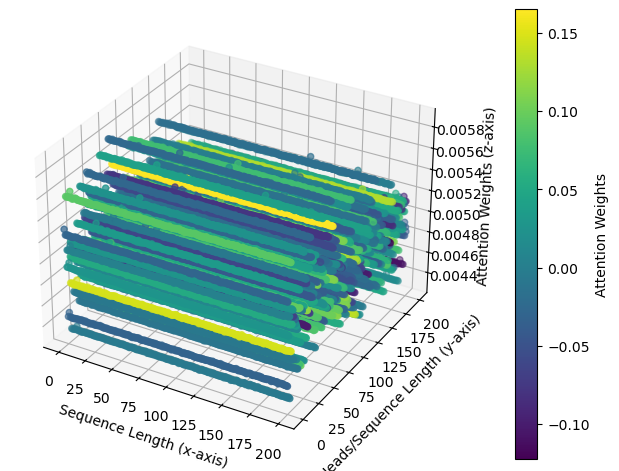

In [96]:
# loading self-attention weights)
caw = decoder_weights.mean(0).cpu().detach().numpy()

# Create a meshgrid for x and y axes
x = np.arange(caw.shape[0])
y = np.arange(caw.shape[1])
x, y = np.meshgrid(x, y)

# Create a meshgrid for x and y axes
x = np.arange(caw.shape[0])
y = np.arange(caw.shape[1])
x, y = np.meshgrid(x, y)

# Transpose the meshgrid to match the shape of attention_weights
x = x.T
y = y.T

# Flatten the x, y, and z (attention_weights) for plotting
x = x.flatten()
y = y.flatten()
z = caw.flatten()

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap
# third distribution is more aligned one
sc = ax.scatter(x, y, z, c=np.dot(caw,dec_chains_test[:200,:]), cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Attention Weights')

# Labels
ax.set_xlabel('Sequence Length (x-axis)')
ax.set_ylabel('Heads/Sequence Length (y-axis)')
ax.set_zlabel('Attention Weights (z-axis)')


plt.tight_layout()
plt.show()


## Previous implementations

In [198]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a # parameter controlling how important are positions
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins) # output layer
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, s, masked_token):
        position_ids = torch.arange(len(s), dtype=torch.long)
        position_ids = position_ids
        s = torch.tensor(s, dtype=torch.float)
        masked_token = torch.tensor(masked_token, dtype=torch.float)
        #print("the sequence with the masked token:", s)
        print("shape of position ids before embedding:", position_ids.shape)
        print("shape the sequence with the masked token:", s.shape)
        print("value of the word embedding:", self.word_embeddings(s).shape)
        print("positional embedding:", self.position_embeddings(position_ids))
        x = self.word_embeddings(s) + self.position_embeddings(position_ids)
        query = self.query_weight(x)
        key = self.key_weight(x)

        values = self.value_weight(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)) # (batch_size,embed_dim)
        exp_scaling = torch.exp(self.word_embeddings(masked_token) + self.position_embeddings(position_ids).T@query.T@key@(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)))
        attn_output = torch.sum(exp_scaling/torch.sum(exp_scaling.sum(0))*values) # not sure it multiplies the way I want it to multiply - check
        output = self.dropout(self.fc(attn_output))
        return output
    
class FactoredAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(FactoredAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Embedding(num_spins, embed_dim)
        self.word_embedding.weight.requires_grad = False
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a # parameter controlling how important are positions
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins) # output layer
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, s, masked_token):
        # masked token should be equal to 0
        # masked_token = torch.tensor([0])
        position_ids = torch.arange(len(s), dtype=torch.long)
        position_ids = position_ids
        x = self.word_embeddings(s) + self.position_embeddings(position_ids)
        query = self.query_weight(x)
        key = self.key_weight(x)

        values = self.value_weight(self.word_embeddings(s)) # (embed_dim)
        exp_scaling = torch.exp(self.word_embeddings(masked_token) + self.position_embeddings(position_ids).T@query.T@key@(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)))
        attn_output = torch.sum(exp_scaling/torch.sum(exp_scaling.sum(0))*values) # not sure it multiplies the way I want it to multiply - check
        output = self.fc(self.dropout(attn_output))
        return output